# K-Nearest Neighbors Classification on Galaxy10 ViT Embeddings

This notebook performs KNN classification using 768-dimensional ViT embeddings extracted from the Galaxy10 dataset.

We include:
- Grid search for best `k`
- Accuracy, balanced accuracy, precision, recall, F1
- Confusion matrix and per-class report
- PCA visualization
- Confusion-based hierarchical class relation analysis

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA

## Load ViT Embedding Vectors

In [79]:
from sklearn.decomposition import PCA
import numpy as np

# Load data
data = np.load('Galaxy10_Embedding_vectors/galaxy10_resnet101_embeddings_augmented_balanced.npz', allow_pickle=True)

# Separate train, val, and test
X_train = data['train_features']
y_train = data['train_labels']

X_val = data['val_features']
y_val = data['val_labels']

X_test = data['test_features']
y_test = data['test_labels']

class_names = data['class_names']

print(f"Original Train size: {X_train.shape[0]}")
print(f"Original Validation size: {X_val.shape[0]}")
print(f"Original Test size: {X_test.shape[0]}")
print(f"Original Embedding dimension: {X_train.shape[1]}")

# Concatenate train and val for PCA fitting
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

# PCA to keep 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_train_val_pca = pca.fit_transform(X_train_val)
X_test_pca = pca.transform(X_test)

# Split back train and val after PCA
X_train_pca = X_train_val_pca[:len(X_train)]
X_val_pca = X_train_val_pca[len(X_train):]

print(f"Reduced Train dimension: {X_train_pca.shape[1]}")
print(f"Reduced Validation dimension: {X_val_pca.shape[1]}")
print(f"Reduced Test dimension: {X_test_pca.shape[1]}")


Original Train size: 48970
Original Validation size: 3269
Original Test size: 3268
Original Embedding dimension: 2048
Reduced Train dimension: 25
Reduced Validation dimension: 25
Reduced Test dimension: 25


## Grid Search for Optimal `k`

In [80]:
# Use only odd k values
k_values = list(range(1, 39, 2))
results = []

# Train on train set, validate on val set
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)  # Only train set
    y_val_pred = knn.predict(X_val)  # Validate on val set
    acc = accuracy_score(y_val, y_val_pred)
    results.append({'k': k, 'accuracy': acc})

results_df = pd.DataFrame(results)

## Plot Accuracy and Balanced Accuracy

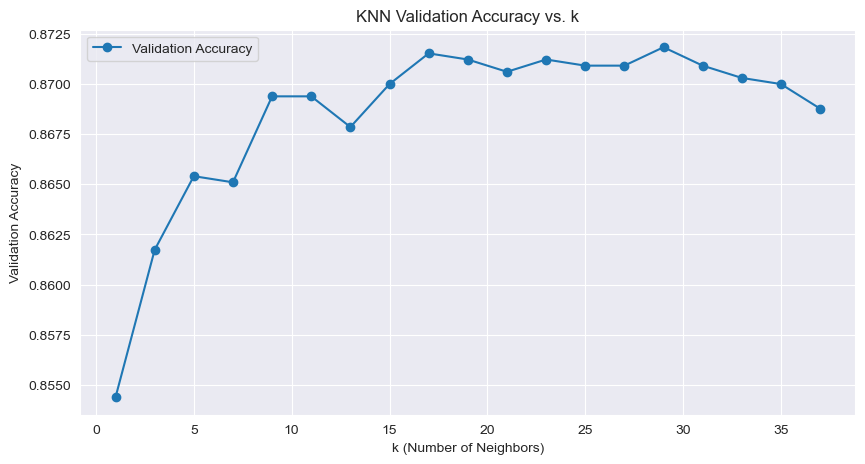

Best k (based on validation accuracy): 29


In [81]:
# Plot accuracy vs k
plt.figure(figsize=(10, 5))
plt.plot(results_df['k'], results_df['accuracy'], marker='o', label='Validation Accuracy')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Validation Accuracy")
plt.title("KNN Validation Accuracy vs. k")
plt.grid(True)
plt.legend()
plt.show()

# Find best k based on validation accuracy
best_k = results_df.loc[results_df['accuracy'].idxmax()]['k']
print(f"Best k (based on validation accuracy): {int(best_k)}")


## Final Evaluation with Best `k`

In [82]:
knn = KNeighborsClassifier(n_neighbors=int(best_k))
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Accuracy:            {acc:.4f}")
print(f"Balanced Accuracy:   {bal_acc:.4f}")
print(f"Macro Precision:     {precision:.4f}")
print(f"Macro Recall:        {recall:.4f}")
print(f"Macro F1 Score:      {f1:.4f}")

Accuracy:            0.8807
Balanced Accuracy:   0.7550
Macro Precision:     0.7617
Macro Recall:        0.7550
Macro F1 Score:      0.7578


## Confusion Matrix

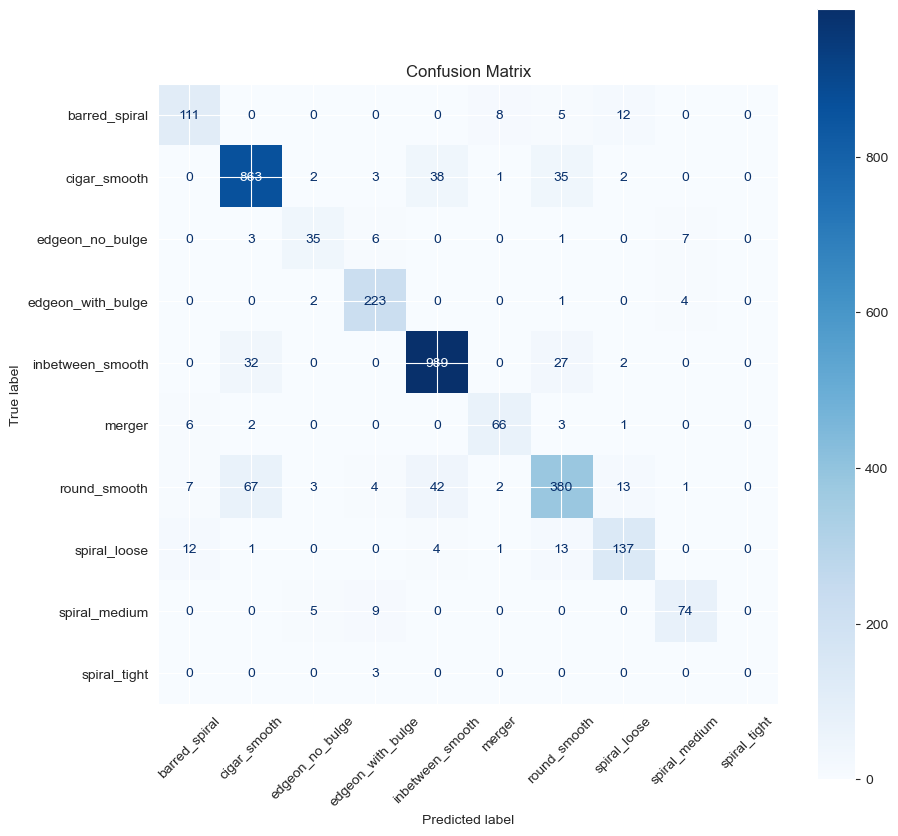

In [83]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

## Classification Report

In [84]:
print(classification_report(y_test, y_pred, target_names=class_names, digits=4, zero_division=0))

                   precision    recall  f1-score   support

    barred_spiral     0.8162    0.8162    0.8162       136
     cigar_smooth     0.8915    0.9142    0.9027       944
  edgeon_no_bulge     0.7447    0.6731    0.7071        52
edgeon_with_bulge     0.8992    0.9696    0.9331       230
 inbetween_smooth     0.9217    0.9419    0.9317      1050
           merger     0.8462    0.8462    0.8462        78
     round_smooth     0.8172    0.7322    0.7724       519
     spiral_loose     0.8204    0.8155    0.8179       168
    spiral_medium     0.8605    0.8409    0.8506        88
     spiral_tight     0.0000    0.0000    0.0000         3

         accuracy                         0.8807      3268
        macro avg     0.7617    0.7550    0.7578      3268
     weighted avg     0.8781    0.8807    0.8788      3268



## PCA Visualization of Test Embeddings

In [85]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

# Reduce to 3D
pca = PCA(n_components=3)
X_test_pca = pca.fit_transform(X_test)

# Create a DataFrame for Plotly (color by predictions now)
df = pd.DataFrame({
    'PC1': X_test_pca[:, 0],
    'PC2': X_test_pca[:, 1],
    'PC3': X_test_pca[:, 2],
    'Prediction': [class_names[i] for i in y_pred]  # <-- Use y_test_pred here
})

# Plot
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3',
                    color='Prediction', title="3D PCA of Test Set Embeddings (Predicted Labels)",
                    width=800, height=600)

fig.update_traces(marker=dict(size=4, opacity=0.7))
fig.show()


### Hierarchical Clustering Based on Embedding Space

To analyze the relationships between classes in the Galaxy10 dataset, we performed hierarchical clustering based on the **mean embedding** (centroid) of each class.

Each centroid was calculated by averaging the feature vectors (embeddings) of all samples in the training and validation sets belonging to the same class. We used **Ward's method** for hierarchical clustering, which minimizes the variance between clusters.

#### Why Not the Confusion Matrix?
- The confusion matrix reflects classifier performance but can be misleading if a class is not predicted at all.
- Some classes may have zero true positives or even zero predictions, making clustering impossible or meaningless.
- In contrast, embeddings are based on the model’s internal representation and exist for all classes, independent of classification outcomes.

#### Optimal Solution Illustration:
The optimal strategy for clustering is:

\[
\text{Distance}(C_i, C_j) = \left\| \mu_i - \mu_j \right\|_2
\]

where:
- \( C_i, C_j \) are class centroids.
- \( \mu_i, \mu_j \) are the mean embedding vectors of class \( i \) and \( j \).
- \( \| \cdot \|_2 \) denotes Euclidean distance.

This approach clusters classes based on how similar they are in the **embedding space**, capturing the semantic structure learned by the model.

#### Summary
- Compute the **mean embedding** for each class.
- Compute **pairwise distances** between class centroids.
- Apply **Ward's linkage** for hierarchical clustering.
- Visualize the dendrogram to interpret the relationships.

This method gives a robust, representation-driven clustering of the Galaxy10 classes.


Skipping class spiral_tight: no predictions in test set.


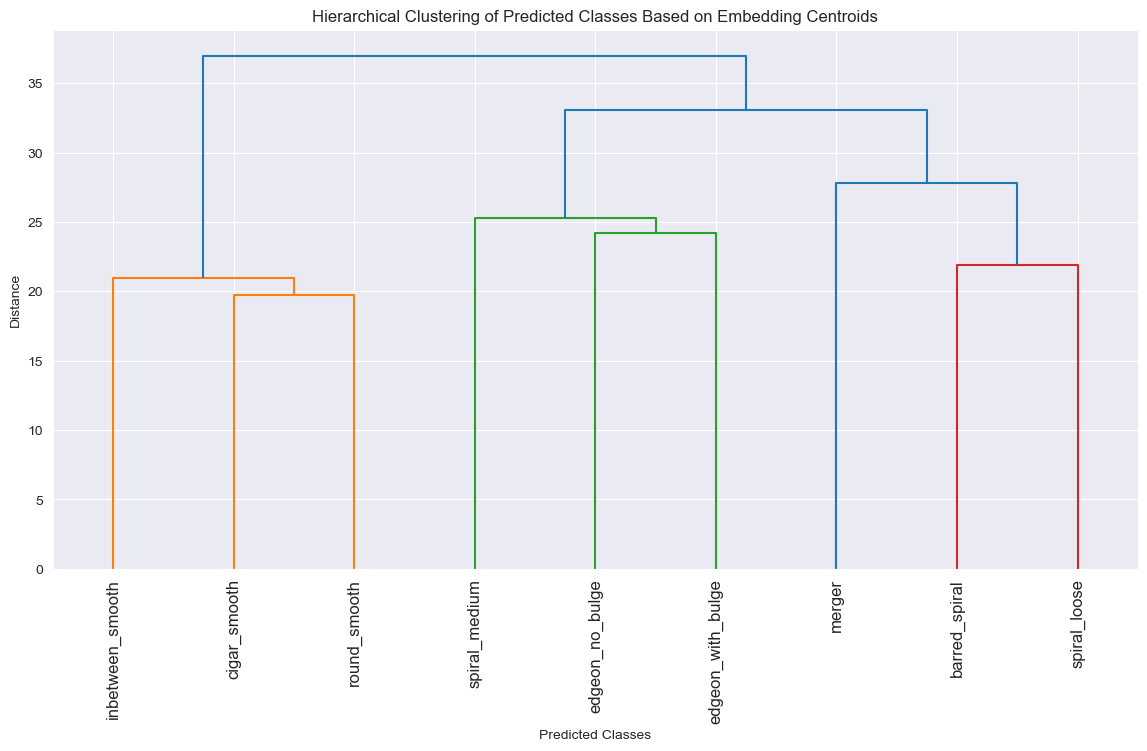

In [86]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import numpy as np

# Make sure class names are a numpy array
class_names = np.array(class_names)

# Find the unique classes predicted by the model
predicted_classes = np.unique(y_pred)

centroids_pred = []
valid_class_names_pred = []

for cls in range(len(class_names)):
    idx = np.where(y_pred == cls)[0]

    if len(idx) == 0:
        print(f"Skipping class {class_names[cls]}: no predictions in test set.")
        continue
    else:
        centroid = np.mean(X_test[idx], axis=0)
        centroids_pred.append(centroid)
        valid_class_names_pred.append(class_names[cls])

centroids_pred = np.array(centroids_pred)
valid_class_names_pred = np.array(valid_class_names_pred)

# Perform hierarchical clustering
linked_pred = linkage(centroids_pred, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 7))
dendrogram(linked_pred, labels=valid_class_names_pred, leaf_rotation=90)
plt.title('Hierarchical Clustering of Predicted Classes Based on Embedding Centroids')
plt.xlabel('Predicted Classes')
plt.ylabel('Distance')
plt.show()
